# Cloud Cover Estimation

### Day Time
Uses simple pixel red-blue ratio to estimate cloud cover. 

Ideally a solar or moon mask would be applied 

Inspired by: https://amt.copernicus.org/articles/12/5519/2019/#bib1.bibx24

TODO
- When computing Cloud Cover Ratio only count pixels in mask area

C:\Users\jdmau\AppData\Local\Temp\ipykernel_24108\2217962472.py:40: RuntimeWarning: divide by zero encountered in divide
  ratio = r / b


% pixels with red-blue ratio greater than 0.75: 51.45855034722222


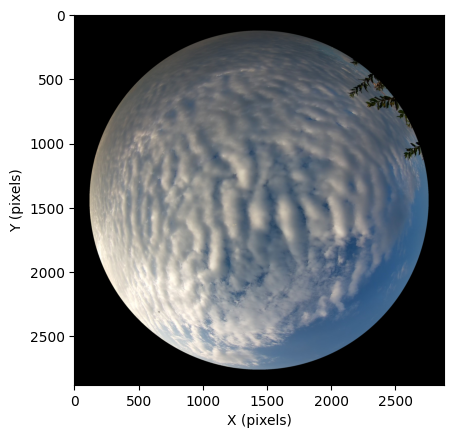

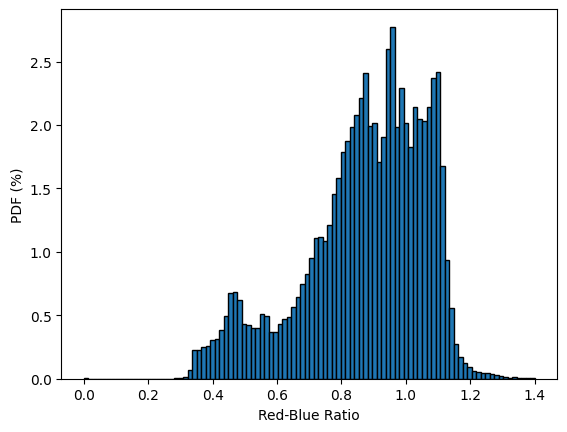

Fraction of area which is cloud covered: 77.98203053230931


True

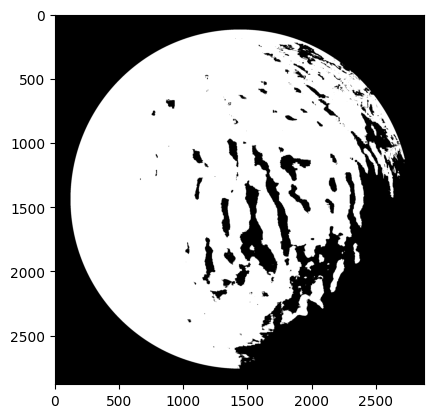

In [86]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

file = 'frames\clear_sun.jpg'
#file = 'frames\heavy_cloud.jpg'
#file = 'frames\partially_cloudy_low.jpg'
file = 'frames\partially_cloudy_med.jpg'

# Read the image
image = cv2.imread(file)

# Get image dimensions
height, width, _ = image.shape

# Create a black image with the same dimensions as the original image
mask = np.zeros((height, width), dtype=np.uint8)

# Draw a circle on the mask image
center = (width // 2, height // 2)
radius = 1320
cv2.circle(mask, center, radius, (255, 255, 255), -1)

# Apply the mask to the original image to remove obstacles at the horizon / distortion
masked_image = cv2.bitwise_and(image, image, mask=mask)

# Converting BGR color to RGB color format and display masked image
RGB_img = cv2.cvtColor(masked_image, cv2.COLOR_BGR2RGB)
plt.figure()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.imshow(RGB_img)
 
# Split the image into its color channels
b, g, r = cv2.split(masked_image)

# Divide the red channel by the blue channel, ignoring division by zero
np.seterr(invalid='ignore')
#ratio = np.where(b > 0, r / b, 1.5)
ratio = r / b

# Threshold the ratio to create a binary cloud mask
ratio_mask = np.where(ratio >= 0.75, 1, 0)
pixels_greater_than_0_75 = np.sum(ratio_mask)
percentage_greater_than_0_75 = pixels_greater_than_0_75 / (height * width) * 100
print("% pixels with red-blue ratio greater than 0.75: " + str(percentage_greater_than_0_75))

if percentage_greater_than_0_75 > 98 or np.max(ratio) < 0.6:
    print('Likely cloudy')
elif percentage_greater_than_0_75 < 2.5:
    print('Likely fully clear')

# Plot the PDF of the ratio values
plt.figure()
hist, bins, _ = plt.hist(ratio.flatten(), bins=100, density=True, range=(0, 1.4), edgecolor = "black")
plt.xlabel('Red-Blue Ratio')
plt.ylabel('PDF (%)')
plt.show()

# Threshold the ratio values to identify pixels that are likely to be clouds
cloud_mask = np.where(ratio > 0.75, 255, 0).astype(np.uint8)

# Display the cloud mask
plt.figure()
plt.imshow(cloud_mask, cmap='gray')

# Estimate of fractional cloud cover
N_Cloudy = pixels_greater_than_0_75
N_Clear = np.sum(np.where(ratio < 0.75, 1, 0))
f = N_Cloudy / (N_Clear + N_Cloudy)
print("Fraction of area which is cloud covered: " + str(f * 100))

# Convert the result to an 8-bit unsigned integer
ratio = np.uint8(ratio)

# Save the result to a new image file
cv2.imwrite('result.jpg', ratio)

### Night Time

Algorithms for with and without moon. 

Inspired by: https://www.mdpi.com/2218-1997/8/10/538

Number of non zero pixels: 820623
Number of zero pixels: 3953026
17.19068578355887


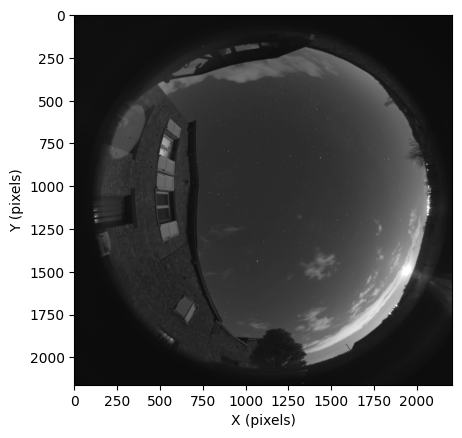

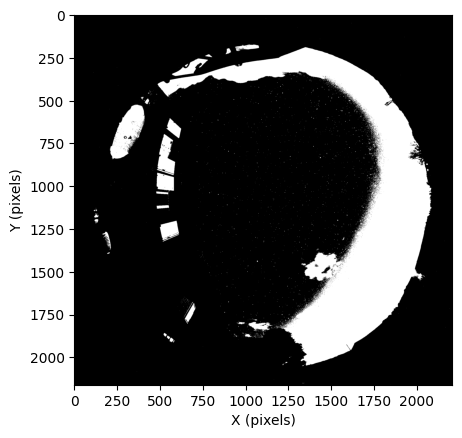

In [91]:
# No moon uses just Otsu thesholding 

# Read the grayscale image
file = 'frames\\night_cloud2.jpg'
image = cv2.imread(file, 0)

# Converting BGR color to RGB color format and display masked image
plt.figure()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.imshow(image, cmap='gray')

otsu_threshold, image_result = cv2.threshold(
    image, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)

# Count the number of non zero pixels (white)
N_Cloud = np.count_nonzero(image_result)
print(f'Number of non zero pixels: {N_Cloud}')

# Count the number of zero pixels (black)
N_Sky = np.count_nonzero(image_result == 0)
print(f'Number of zero pixels: {N_Sky}')

ccr = (N_Cloud / (N_Cloud + N_Sky)) * 100
print(ccr)

plt.figure()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.imshow(image_result, cmap='gray')

Number of non zero pixels: 400423
Number of zero pixels: 4072847
Cloud cover ratio: 8.951460564642867


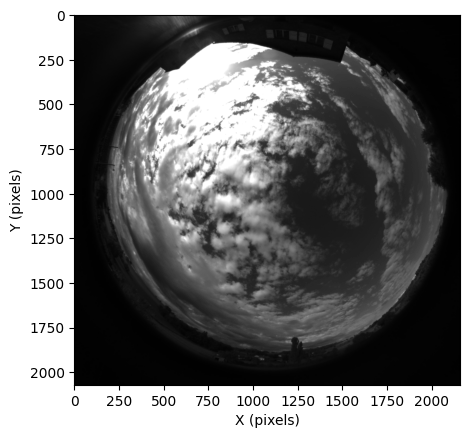

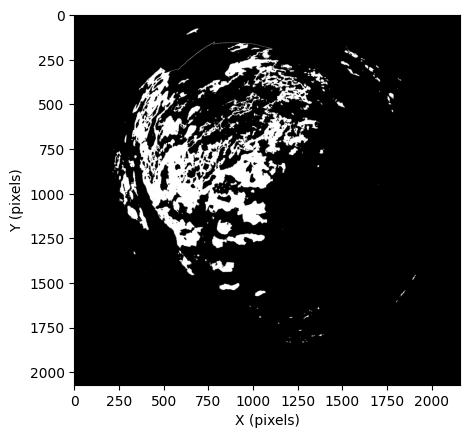

In [90]:
# With moon uses just color correction approach with Otsu thesholding 

# Read the grayscale image
file = 'frames\\night_cloud.jpg'
image = cv2.imread(file, 0)
stacked_img = np.stack((image,)*3, axis=-1)

plt.figure()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.imshow(image, cmap='gray')

# Invert the image
inverted_image = cv2.bitwise_not(stacked_img)

# Split the channels of the masked image
b, g, r = cv2.split(inverted_image)

# Apply the color correction formula
r = 1.164 * (r - 16) + 1.596 * (r - 128)
g = 1.164 * (g - 16) - 0.392 * (g - 128) - 0.813 * (g - 128 )
b = 1.164 * (b - 16) + 2.017 * (b - 128)

# Find the min and max value for each pixel over the RGB channels
maximum = np.maximum(np.maximum(b, g), r)
minimum = np.minimum(np.minimum(b, g), r)

# Feature image
f = (maximum - minimum) / maximum
f = f.astype('uint8')

otsu_threshold, image_result = cv2.threshold(
    f, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU,
)

N_Cloud = np.count_nonzero(image_result)
print(f'Number of non zero pixels: {N_Cloud}')

# Count the number of zero pixels in the masked image
N_Sky = np.count_nonzero(image_result == 0)
print(f'Number of zero pixels: {N_Sky}')

# Cloud cover ratio
ccr = (N_Cloud / (N_Cloud + N_Sky)) * 100
print(f'Cloud cover ratio: {ccr}')

# Plot the segmentation map
plt.figure()
plt.xlabel('X (pixels)')
plt.ylabel('Y (pixels)')
plt.imshow(f, cmap='gray')

In [ ]:
# Solar mask
# mask = np.zeros((height, width), dtype=np.uint8)
# center = (1500, height // 3)
# radius = 350
# cv2.circle(mask, center, radius, (255, 255, 255), -1)
# masked_image = cv2.bitwise_and(masked_image, masked_image, mask=255-mask)